#### This post is for practice purpose and illustrates two ways of building a linear regression model in python

## 1) build a linear regression model from scratch

In [1]:
# import packages

import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

%matplotlib inline
print(torch.__version__)

1.4.0


In [2]:
# generate the dataset
num_inputs = 2
num_examples = 1000

# set true weight and bias in order to generate corresponded label
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b

# add torch generated noises
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

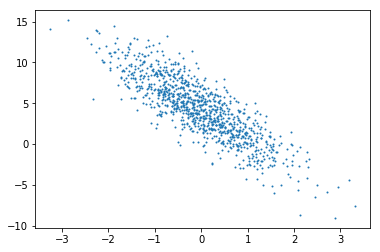

In [3]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

In [4]:
# now load my toy dataset

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # random read 10 samples
    
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) 
        # the last time may be not enough for a whole batch
        
        yield  features.index_select(0, j), labels.index_select(0, j)

In [5]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.9869, -1.5646],
        [ 0.0087,  0.1067],
        [-0.1179, -1.0161],
        [-1.2753,  0.6361],
        [ 0.2479, -1.5121],
        [-2.1122, -0.0738],
        [ 0.2753, -0.3803],
        [-2.9495, -0.4552],
        [ 1.9585, -0.6960],
        [ 0.3675, -1.0220]]) 
 tensor([ 7.5529,  3.8514,  7.4193, -0.5013,  9.8427,  0.2352,  6.0449, -0.1494,
        10.4776,  8.4064])


In [6]:
# initializing the params

w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [7]:
# define model

def linreg(X, w, b):
    return torch.mm(X, w) + b

In [8]:
# define loss function

def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

In [9]:
# define optimizer

def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size # ues .data to operate param without gradient track

In [10]:
# initializing hyperparam
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

# training
for epoch in range(num_epochs): 
    # in each epoch, all the samples in dataset will be used once
    
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  
        
        # calculate the gradient of batch sample loss 
        l.backward()  
        
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        
        # reset parameter gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
        
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.038319
epoch 2, loss 0.000141
epoch 3, loss 0.000051
epoch 4, loss 0.000050
epoch 5, loss 0.000050
epoch 6, loss 0.000050
epoch 7, loss 0.000050
epoch 8, loss 0.000050
epoch 9, loss 0.000050
epoch 10, loss 0.000050


In [11]:
w, true_w, b, true_b

(tensor([[ 2.0000],
         [-3.3997]], requires_grad=True),
 [2, -3.4],
 tensor([4.2008], requires_grad=True),
 4.2)

In [12]:
## the model prediction is quite close to the true values 
## though this was a simple linear regression model

## 2) using the built-in model of Pytorch

In [28]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(210)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.4.0


In [29]:
# again generate the toy dataset

num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [30]:
import torch.utils.data as Data

batch_size = 10

# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,            # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # whether shuffle the data or not
    num_workers=2,              # read data in multithreading
)

In [31]:
# check for the dataset

for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[ 1.0353,  0.0804],
        [ 0.0539,  0.7747],
        [ 1.5655,  0.0302],
        [ 0.0885,  0.0698],
        [ 0.2294, -0.7081],
        [ 1.4852, -0.6646],
        [ 1.3994, -1.4422],
        [ 1.2073,  1.3330],
        [ 0.8155,  1.7890],
        [ 0.0277,  1.3200]]) 
 tensor([ 5.9852,  1.6732,  7.2229,  4.1476,  7.0591,  9.4245, 11.8960,  2.0889,
        -0.2713, -0.2325])


In [34]:
# start building the model

class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()     
        # call function to init 
        self.linear = nn.Linear(n_feature, 1)  
        # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`

    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)

print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [37]:
# 3 ways to init a multilayer network

## method one
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be also added here
    )

## method two
net1 = nn.Sequential()
net1.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

## method three
from collections import OrderedDict
net2 = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

#print(net1)
#print(net2)

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [38]:
# initializing the params

from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)

Parameter containing:
tensor([0.], requires_grad=True)

In [39]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.0129, 0.0105]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [40]:
# cost function

loss = nn.MSELoss()    # function prototype: `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`

In [41]:
# optimizer

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)  # function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [42]:
# start training

num_epochs = 5

for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad()
        l.backward()
        optimizer.step()
        
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000565
epoch 2, loss: 0.000113
epoch 3, loss: 0.000112
epoch 4, loss: 0.000156
epoch 5, loss: 0.000072


In [43]:
# result comparision

dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 1.9997, -3.4000]])
4.2 tensor([4.1994])


In [44]:
## the nn model also performs quite well being a simple linear regression model